In [1]:
from bayes_filter.filters import FreeTransitionSAEM
import tensorflow as tf
import tensorflow_probability as tfp
import os
from bayes_filter.misc import load_array_file
from bayes_filter import float_type
import sys
from bayes_filter.data_feed import IndexFeed,TimeFeed,CoordinateFeed, DataFeed, init_feed, ContinueFeed
from bayes_filter.coord_transforms import tf_coord_transform, itrs_to_enu_with_references
from bayes_filter.kernels import DTECIsotropicTimeGeneralODE, DTECIsotropicTimeGeneral
import astropy.time as at
import astropy.coordinates as ac
import astropy.units as au
from bayes_filter.frames import ENU
import numpy as np
import pylab as plt
from scipy.spatial import cKDTree
import seaborn as sns
from timeit import default_timer
from bayes_filter.settings import angle_type, dist_type


def arrays():
    return os.path.dirname(sys.modules["bayes_filter"].__file__)

def lofar_array(arrays):
    lofar_array = os.path.join(arrays, 'arrays/lofar.hba.antenna.cfg')
    return load_array_file(lofar_array)

def lofar_array2(arrays):
    lofar_array = os.path.join(arrays, 'arrays/lofar.hba.antenna.cfg')
    res = load_array_file(lofar_array)
    return res[0][[0,48,49,50, 51]], res[1][[0,48,49,50,51],:]


def simulated_ddtec(tf_session, lofar_array):
    class Simulated:
        def __init__(self):
            ref_ant = lofar_array[1][0,:]

            Nt, Nd, Na, Nf = 1, 20, len(lofar_array[0])-1, 6

            with tf_session.graph.as_default():
                index_feed = IndexFeed(Nt)
                obstime_init = at.Time("2018-01-01T00:00:00.000", format='isot')
                times = obstime_init.mjd*86400. + tf.cast(tf.linspace(0., Nt*30., Nt)[:, None],float_type)
                time_feed = TimeFeed(index_feed, times)
                cont_feed = ContinueFeed(time_feed)
                enu = ENU(location=ac.ITRS(*ref_ant * au.m), obstime=obstime_init)
                up = ac.SkyCoord(east=0., north=0., up=1., frame=enu).transform_to('icrs')

                M = 20
                self.M = M
                ra_vec = np.linspace(up.ra.rad  - 2. * np.pi / 180., up.ra.rad  + 0. * np.pi / 180., M)
                dec_vec = np.linspace(up.dec.rad - 2. * np.pi / 180., up.dec.rad + 2. * np.pi / 180., M)
                self.data_extent = (ra_vec[0], ra_vec[-1], dec_vec[0], dec_vec[-1])
                ra, dec = np.meshgrid(ra_vec, dec_vec, indexing='ij')
                ra = ra.flatten()[:, None]
                dec = dec.flatten()[:, None]

                Nd = ra.shape[0]
                Xd  = tf.concat([ra, dec], axis=1)
                Xa  = tf.constant(lofar_array[1][1:,:], dtype=float_type)
                coord_feed = CoordinateFeed(time_feed, Xd, Xa,
                                            coord_map=tf_coord_transform(itrs_to_enu_with_references(ref_ant, [up.ra.rad, up.dec.rad], ref_ant)))
                ra_vec = np.linspace(up.ra.rad - 2. * np.pi / 180., up.ra.rad + 2. * np.pi / 180., M)
                dec_vec = np.linspace(up.dec.rad - 2. * np.pi / 180., up.dec.rad + 2. * np.pi / 180., M)
                self.star_extent = (ra_vec[0], ra_vec[-1], dec_vec[0], dec_vec[-1])
                ra, dec = np.meshgrid(ra_vec, dec_vec, indexing='ij')
                ra = ra.flatten()[:, None]
                dec = dec.flatten()[:, None]
                Nd_screen = ra.shape[0]

                Xd_screen = tf.concat([ra, dec], axis=1)
                star_coord_feed = CoordinateFeed(time_feed, Xd_screen, Xa,
                                                 coord_map=tf_coord_transform(itrs_to_enu_with_references(ref_ant, [up.ra.rad, up.dec.rad], ref_ant)))
                init, next = init_feed(coord_feed)
                init_star, next_star = init_feed(star_coord_feed)
                init_cont, cont = init_feed(cont_feed)
                Xd_screen, Xd, _,_,_ = tf_session.run([Xd_screen, Xd, init, init_cont, init_star])
                kern = DTECIsotropicTimeGeneral(variance=1e-4,timescale=45.,lengthscales=5., a=300., b=100.,
                                         fed_kernel='RBF',obs_type='DDTEC', squeeze=True, kernel_params={'resolution':3})
                # kern = tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(tf.convert_to_tensor(0.04,float_type), tf.convert_to_tensor(10.,float_type))
                self.slice_size = Nt * Xd_screen.shape[0] * Xa.shape[0] + Nt * Xd.shape[0] * Xa.shape[0]

                kd = cKDTree(Xd)
                self.nearest, idx = kd.query(Xd_screen, k=1)
                self.nearest *= 180./np.pi
                from timeit import default_timer
                t0 = default_timer()
                Y_real, Y_imag = [],[]
                Y_real_star, Y_imag_star = [], []
                ddtec_true, ddtec_star = [],[]
                while True:
                    K,N = tf_session.run([kern.K(tf.concat([next,next_star],axis=0)),tf.shape(next)[0]])
                    s = np.mean(np.diag(K))
                    L = np.sqrt(s)*np.linalg.cholesky(K/s+1e-6*np.eye(K.shape[-1]))
                    np.random.seed(0)
                    ddtec = np.einsum('ab,b->a',L, np.random.normal(size=L.shape[1]))
                    ddtec_true.append(ddtec[:N])
                    ddtec_star.append(ddtec[N:])
                    freqs = np.linspace(110.e6, 160.e6, Nf)
                    Y_real.append(np.cos(-8.448e9 * ddtec[:N,None]/freqs))
                    Y_imag.append(np.sin(-8.448e9 * ddtec[:N, None] / freqs))
                    Y_real_star.append(np.cos(-8.448e9 * ddtec[N:, None] / freqs))
                    Y_imag_star.append(np.sin(-8.448e9 * ddtec[N:, None] / freqs))
                    if not tf_session.run(cont):
                        break
                self.Y_real_star = np.concatenate(Y_real_star,axis=0).reshape((Nt, Nd_screen, Na, Nf))
                self.Y_imag_star = np.concatenate(Y_imag_star, axis=0).reshape((Nt, Nd_screen, Na, Nf))
                Y_real_true = np.concatenate(Y_real,axis=0).reshape((Nt, Nd, Na, Nf))
                Y_real = Y_real_true + 0.5*np.random.normal(size=Y_real_true.shape)
                # Y_real[Nt//2:Nt//2 + 5, ...] *= 0.5
                Y_imag_true = np.concatenate(Y_imag, axis=0).reshape((Nt, Nd, Na, Nf))
                Y_imag = Y_imag_true + 0.5 * np.random.normal(size=Y_imag_true.shape)
                # Y_imag[Nt // 2:Nt // 2 + 5, ...] *= 0.5
                self.freqs = freqs
                self.ddtec_true = np.concatenate(ddtec_true,axis=0).reshape((Nt, Nd, Na))
                self.ddtec_star = np.concatenate(ddtec_star, axis=0).reshape((Nt, Nd_screen, Na))
                self.Y_real = Y_real
                self.Y_imag = Y_imag
                self.Y_real_true = Y_real_true
                self.Y_imag_true = Y_imag_true
                # self.np_freqs = tf_session.run(freqs)
                self.np_times = tf_session.run(times)
                self.ddtec = ddtec
                self.coord_feed = coord_feed
                self.star_coord_feed = star_coord_feed
                self.data_feed = DataFeed(index_feed, Y_real, Y_imag, event_size=1)
    return Simulated()

if __name__ == '__main__':
    from tensorflow.python import debug as tf_debug
    sess = tf.Session(graph=tf.Graph())
    # sess = tf_debug.LocalCLIDebugWrapperSession(sess)
    with sess.graph.as_default():
        simulated_ddtec = simulated_ddtec(sess, lofar_array2(arrays()))

        free_transition = FreeTransitionSAEM(
            simulated_ddtec.freqs,
            simulated_ddtec.data_feed,
            simulated_ddtec.coord_feed,
            simulated_ddtec.star_coord_feed)

        filtered_res, inits = free_transition.filter_step(
            num_samples=2000, num_chains=2,parallel_iterations=10, num_leapfrog_steps=3,target_rate=0.6,
            num_burnin_steps=1000,num_saem_samples=2000,saem_maxsteps=20,initial_stepsize=7e-3,
            init_kern_params={'y_sigma':0.5,'variance':0.5e-4,'timescale':45.,'lengthscales':15., 'a':500., 'b':60.},
            which_kernel=0, kernel_params={'resolution':3}, saem_batchsize=500, 
            slice_size=simulated_ddtec.slice_size)

        sess.run(inits[0])
        sess.run(inits[1])
        sess.run(inits[2])
        cont = True
        while cont:
            res = sess.run(filtered_res)
            print("rhat:",np.percentile(res.rhat,[10,50,90]))
            plt.hist(res.rhat, bins = int(np.sqrt(len(res.rhat))))
            plt.show()
            # plt.plot(res.step_sizes)
            # plt.show()
            # plt.hist(res.ess.flatten(),bins=100)
            # plt.show()
            times = simulated_ddtec.np_times[:,0]
            ddtec_true = simulated_ddtec.ddtec_true
            ddtec_star = simulated_ddtec.ddtec_star
            Y_real_star = simulated_ddtec.Y_real_star
            Y_imag_star = simulated_ddtec.Y_imag_star


            # plt.plot(times, res.Y_imag[1,:,0,1,0],c='black',lw=2.)
            # plt.fill_between(times, res.Y_imag[0,:,0,1,0], res.Y_imag[2,:,0,1,0],alpha=0.5)
            # plt.plot(times, res.extra.Y_imag_data[:, 0, 1, 0], c='red', lw=1.)
            # plt.plot(times, simulated_ddtec.Y_imag_true[:, 0, 1, 0], c='green', lw=1.)
            # plt.show()
            ct = 1# -8.448e9/140e6
            vmin, vmax = np.percentile(ct*res.dtec_star[1, ...], [5, 95])

            plt.style.use('ggplot')
            fig, axs = plt.subplots((simulated_ddtec.Y_imag_true.shape[2]), 4, figsize=(12,4*(simulated_ddtec.Y_imag_true.shape[2])),sharex=True,sharey=True)
            # ax1,ax2, ax3 = axs[0]

            # ax1.imshow(res.dtec[1, 0, :, 1].reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
            #            extent=simulated_ddtec.data_extent, 
            #            vmin=vmin,vmax=vmax)
            # ax1.set_title("Model space solution")

            # ax2.imshow(simulated_ddtec.dtec_star[0, :, 1].reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
            #            extent=simulated_ddtec.star_extent,
            #            vmin=vmin,vmax=vmax)
            # ax2.set_title("Data space solution")
            # ax2.legend()

            ant_names = lofar_array2(arrays())[0][1:]

            for i in range(simulated_ddtec.Y_imag_true.shape[2]):
                ax3,ax4,ax5,ax6 = axs[i]

                ax3.imshow(ct*simulated_ddtec.ddtec_true[0, :, i].reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
                           extent=simulated_ddtec.data_extent,vmin=vmin,vmax=vmax)
                ax3.set_ylabel(ant_names[i])


                ax4.imshow(ct*res.dtec_star[1, 0, :, i].reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
                           extent=simulated_ddtec.star_extent,vmin=vmin,vmax=vmax)


                img = ax5.imshow(ct*(ddtec_star[0, :, i]).reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
                                 extent=simulated_ddtec.star_extent, vmin=vmin,vmax=vmax)


                img = ax6.imshow(ct*np.abs(res.dtec_star[1, 0, :, i] - ddtec_star[0, :, i]).reshape((simulated_ddtec.M,simulated_ddtec.M)).T,
                                 extent=simulated_ddtec.star_extent, vmin=vmin,vmax=vmax)
                if i == 0:
                    ax3.set_title(r"Obs. $\Delta^2$TEC")
                    ax4.set_title(r"Median inferred $\Delta^2$TEC*")
                    ax5.set_title(r"True $\Delta^2$TEC*")
                    ax6.set_title(r"Residual $\Delta^2$TEC")

            #         ax3.set_title(r"True $\Delta^2$TEC(X)")
            #         ax4.set_title(r"Median $\Delta^2$TEC(X*)")
            #         ax5.set_title(r"True $\Delta^2$TEC(X*)")
            #         ax6.set_title(r"Residual $\Delta^2$TEC(X*)")

            # plt.tight_layout()
            cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
            cb = plt.colorbar(img, cax = cbaxes)  
            plt.savefig('screen_interpolation.png')
            plt.show()
            # error = np.sqrt(np.square(res.Y_imag_star[1, :, :, :, :]-simulated_ddtec.Y_imag_star[:, :, :, :]).mean(3).mean(2).mean(0))
            # plt.scatter(simulated_ddtec.nearest,error)
            # x = simulated_ddtec.nearest[:, None]
            # a, _, _, _ = np.linalg.lstsq(x, error)
            # plt.plot(x, a * x, 'r-')
            # plt.show()

            error = np.sqrt(
                np.square(ct*res.dtec_star[1, :, :, :] - ct*simulated_ddtec.ddtec_star[:, :, :]).mean(
                    2).mean(0))
            plt.scatter(simulated_ddtec.nearest, error)
            x = simulated_ddtec.nearest[:, None]
            a, _, _, _ = np.linalg.lstsq(x, error)
            plt.plot(x, a * x, 'r-')
            plt.xlabel('Nearest facet angular distance (deg)')
            plt.ylabel('Residual phase (rad)')
            plt.show()
            cont = res.cont

Limited tf.compat.v2.summary API due to missing TensorBoard installation


W0226 00:09:37.385010 140146821879616 deprecation.py:323] From /home/albert/miniconda3/envs/bayes_filter/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:442: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0226 00:09:37.422290 140146821879616 deprec

[1] 1 [[1.067247550805289 1.0828141683466783 1.105192378817597 ... 1.2239414672788063 10.47235433901249 8.4703569237766274]]
Rhat: [1.0765017659845226 3.4839177711134215 16.779970460997138]
logProb: -1032165.7397825494 m: DTECToGainsParams(y_sigma=[[0.65149777831693334]], variance=[[3.3686409676672735e-05]], lengthscales=[[18.549637943977714]], a=[[802.1688833484227]], b=[[79.709314246998758]], timescale=[[36.0153672861279]])
logProb: -6118.20567511467 m: DTECToGainsParams(y_sigma=[[0.5]], variance=[[5e-05]], lengthscales=[[15.000000000000002]], a=[[500]], b=[[60]], timescale=[[44.999999999999993]])
logProb: 4207.6296109664545 m: DTECToGainsParams(y_sigma=[[0.59851837953622133]], variance=[[0.00010126832637987748]], lengthscales=[[14.456349394221439]], a=[[516.95969743600335]], b=[[121.73127516933745]], timescale=[[36.976695475689461]])
logProb: -419431.24437655223 m: DTECToGainsParams(y_sigma=[[0.48426994381461463]], variance=[[1.9832247153763614e-05]], lengthscales=[[9.73922950170933

logProb: 3819.8315238652422 m: DTECToGainsParams(y_sigma=[[0.51009689062728059]], variance=[[6.3420765120832942e-05]], lengthscales=[[13.77346807669066]], a=[[691.87416483465415]], b=[[210.62554242238485]], timescale=[[12.93713333246251]])
logProb: -9321.351738885598 m: DTECToGainsParams(y_sigma=[[0.37377628631428234]], variance=[[5.9015228603434586e-05]], lengthscales=[[3.7550447329605077]], a=[[585.55146775037645]], b=[[34.473245165227922]], timescale=[[91.335876616476625]])
logProb: 1541.8984130861509 m: DTECToGainsParams(y_sigma=[[0.73933982651537311]], variance=[[6.0157587817028512e-05]], lengthscales=[[14.767516111490295]], a=[[529.87560853445325]], b=[[82.963425783680862]], timescale=[[55.244079394524015]])logProb: -21781.555230348305 m: DTECToGainsParams(y_sigma=[[0.335559334219897]], variance=[[2.4285728150603448e-05]], lengthscales=[[4.3083396888322909]], a=[[284.33895939166064]], b=[[43.173965932718261]], timescale=[[33.585855658927684]])

logProb: 4232.9559750506651 m: DTEC

logProb: 4070.4910537177561 m: DTECToGainsParams(y_sigma=[[0.65943690941800481]], variance=[[8.6720586804783458e-05]], lengthscales=[[8.8617820177330131]], a=[[509.99501533814174]], b=[[95.5254208322591]], timescale=[[49.159877480190261]])
logProb: 4234.7862185094473 m: DTECToGainsParams(y_sigma=[[0.39177408830979477]], variance=[[0.00010393431090271728]], lengthscales=[[8.8360173000853024]], a=[[398.70875488652268]], b=[[118.36011565480528]], timescale=[[140.84271036354]])
logProb: 104.64921684860747 m: DTECToGainsParams(y_sigma=[[0.43600633623322815]], variance=[[0.00010126832637987748]], lengthscales=[[19.359022570476458]], a=[[453.67429108426188]], b=[[159.54669185962211]], timescale=[[63.432290050020427]])
logProb: 4068.4564225081272 m: DTECToGainsParams(y_sigma=[[0.31185259115705766]], variance=[[5.5458067889842006e-05]], lengthscales=[[7.0461262050306592]], a=[[397.57371584489806]], b=[[134.90080202517862]], timescale=[[175.30923016034822]])
logProb: 4215.1254316856975 m: DTECTo

logProb: 4264.6497179377129 m: DTECToGainsParams(y_sigma=[[0.44821262969853659]], variance=[[8.1363642733835122e-05]], lengthscales=[[9.67784442491602]], a=[[413.73126368347471]], b=[[148.53182008929929]], timescale=[[124.37047634296016]])
logProb: 4203.2302070678816 m: DTECToGainsParams(y_sigma=[[0.80210941449945738]], variance=[[0.00013896383577789641]], lengthscales=[[12.779147176078149]], a=[[425.05174046495313]], b=[[105.12225473641499]], timescale=[[63.730831818914595]])
logProb: 4210.0621119714579 m: DTECToGainsParams(y_sigma=[[0.550105262884983]], variance=[[0.0001016068612427077]], lengthscales=[[12.518094290945797]], a=[[423.69147431388694]], b=[[118.44413131715214]], timescale=[[88.817105049966813]])
logProb: 4287.1475364921989 m: DTECToGainsParams(y_sigma=[[0.64381109072835319]], variance=[[0.00013290136115607553]], lengthscales=[[12.200249959124783]], a=[[454.52446200518415]], b=[[109.55316426122475]], timescale=[[65.735348596951937]])
logProb: 4284.7806342659924 m: DTECTo

logProb: 4280.3302097655869 m: DTECToGainsParams(y_sigma=[[0.45758605904858429]], variance=[[0.00011106483743663129]], lengthscales=[[10.869866467060685]], a=[[453.89743379226962]], b=[[111.32874433646286]], timescale=[[77.652016826907]])
logProb: 4273.1394720274129 m: DTECToGainsParams(y_sigma=[[0.42702259950547805]], variance=[[0.00012837088188824832]], lengthscales=[[12.154999261210953]], a=[[452.68341941856414]], b=[[131.58562869985786]], timescale=[[66.41705730897209]])
logProb: 4285.1576510088162 m: DTECToGainsParams(y_sigma=[[0.54627009365548218]], variance=[[0.00013539013808184808]], lengthscales=[[12.608900101984942]], a=[[481.45337399288951]], b=[[99.766165624609556]], timescale=[[52.288795591307405]])
logProb: 4272.8780688601828 m: DTECToGainsParams(y_sigma=[[0.48212831471461248]], variance=[[0.00013950609774615155]], lengthscales=[[12.131042768953687]], a=[[458.06100349344172]], b=[[91.3053311236994]], timescale=[[43.55767775146694]])
logProb: 4255.1211727690661 m: DTECToGa

logProb: 4204.8733439784628 m: DTECToGainsParams(y_sigma=[[0.54009551130618949]], variance=[[8.7855544220569819e-05]], lengthscales=[[11.152614414751707]], a=[[440.92495079010217]], b=[[106.44236901711974]], timescale=[[102.90274757899488]])
logProb: 4297.12646627278 m: DTECToGainsParams(y_sigma=[[0.67939813375100477]], variance=[[0.00010882201382031925]], lengthscales=[[12.566317692439753]], a=[[464.26874884759496]], b=[[122.58853912708118]], timescale=[[77.61093193814952]])
logProb: 4287.2188180993853 m: DTECToGainsParams(y_sigma=[[0.65887862103209616]], variance=[[0.00012294623278330771]], lengthscales=[[13.080374303031013]], a=[[472.55248057827816]], b=[[107.0501440639033]], timescale=[[59.152156421693938]])
logProb: 4294.4579548289548 m: DTECToGainsParams(y_sigma=[[0.6895383944776835]], variance=[[0.00010231860878170288]], lengthscales=[[12.029212731313955]], a=[[462.36560631961061]], b=[[141.93903816140445]], timescale=[[87.98955852942079]])
logProb: 4289.4094447257739 m: DTECToG

<Figure size 640x480 with 1 Axes>

<Figure size 1200x1600 with 17 Axes>

/home/albert/miniconda3/envs/bayes_filter/lib/python3.7/site-packages/ipykernel_launcher.py:243: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<Figure size 640x480 with 1 Axes>

In [3]:
%matplotlib inline

rhat: [1.00357052 1.08491968 1.49817301] [1.08683597 1.27069069 1.45917514 ... 1.22533058 1.01448681 1.6305369 ]


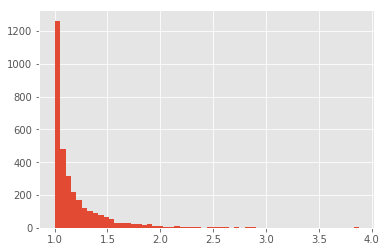

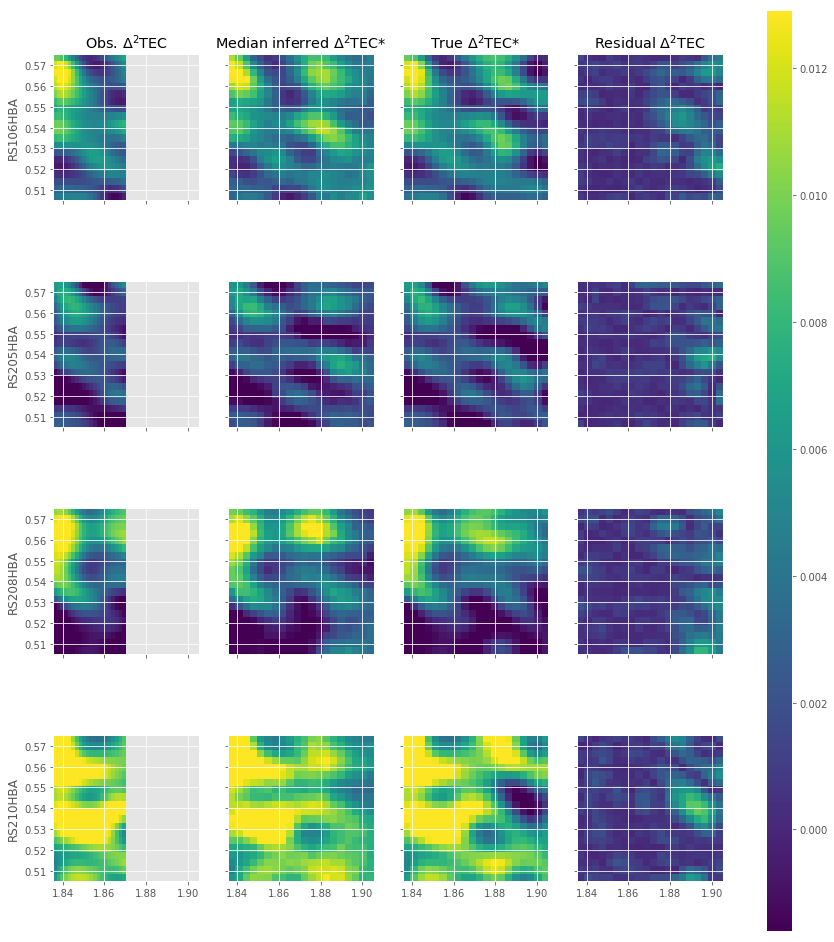

/home/albert/miniconda3/envs/bayes_filter/lib/python3.7/site-packages/ipykernel_launcher.py:87: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


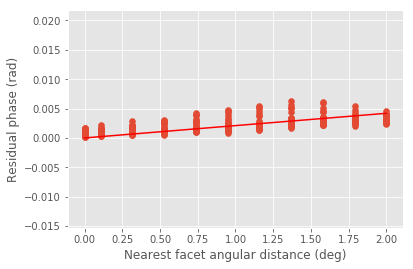

In [48]:
# print("post_logp", res.post_logp,"test_logp", res.test_logp)


In [2]:
plt.show()